In [46]:
import torch
import torch.nn as nn
import torch.quantization
import onnx
import onnxruntime as ort
import numpy as np
import time
from pathlib import Path

In [ ]:
## 4️⃣ 성능 비교 및 평가
def evaluate_pytorch_model(model, test_loader, model_name="PyTorch"):
    """PyTorch 모델 평가"""
    model.eval()
    correct = 0
    total = 0
    
    start_time = time.time()
    
    with torch.no_grad():
        for x, y in test_loader:
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    
    inference_time = time.time() - start_time
    accuracy = 100. * correct / total
    
    print(f"\n{'='*50}")
    print(f"📊 {model_name} 모델 평가 결과")
    print(f"{'='*50}")
    print(f"정확도: {accuracy:.2f}%")
    print(f"추론 시간: {inference_time:.4f}초")
    print(f"샘플당 시간: {inference_time/total*1000:.4f}ms")
    
    return accuracy, inference_time


def evaluate_onnx_model(onnx_path, test_loader):
    """ONNX 모델 평가"""
    ort_session = ort.InferenceSession(str(onnx_path))
    
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for x, y in test_loader:
        # ONNX 입력 형식으로 변환
        ort_inputs = {ort_session.get_inputs()[0].name: x.numpy()}
        ort_outputs = ort_session.run(None, ort_inputs)
        
        predicted = np.argmax(ort_outputs[0], axis=1)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum()
    
    inference_time = time.time() - start_time
    accuracy = 100. * correct / total
    
    print(f"\n{'='*50}")
    print(f"📊 ONNX 모델 평가 결과")
    print(f"{'='*50}")
    print(f"정확도: {accuracy:.2f}%")
    print(f"추론 시간: {inference_time:.4f}초")
    print(f"샘플당 시간: {inference_time/total*1000:.4f}ms")
    
    return accuracy, inference_time



In [48]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
# 데이터 로더 준비 (MNIST 예시)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)



In [ ]:
from pathlib import Path 
# 로드
weights_path = Path("mlp_models/mission_16_original.pth") 
model = SimpleMLP()
model.load_state_dict(torch.load(weights_path))
model.eval()
# 1. 원본 모델 평가
acc_original, time_original = evaluate_pytorch_model(model, test_loader, "원본 PyTorch")

# 양자화된 모델 구조를 다시 생성
quantized_model = SimpleMLP()
quantized_model = torch.quantization.quantize_dynamic(
    quantized_model, {torch.nn.Linear}, dtype=torch.qint8
)

# 양자화된 가중치 로드
quantized_path = Path("mlp_models/mission_16_quantized.pth") 
quantized_model.load_state_dict(torch.load(quantized_path))
quantized_model.eval()
# 2. 양자화 모델 평가
acc_quantized, time_quantized = evaluate_pytorch_model(quantized_model, test_loader, "양자화 PyTorch")

# ONNX 로드
onnx_path = Path("mlp_models/mission_16_model.onnx")
# 3. ONNX 모델 평가
acc_onnx, time_onnx = evaluate_onnx_model(onnx_path, test_loader)



📊 원본 PyTorch 모델 평가 결과
정확도: 97.48%
추론 시간: 2.0659초
샘플당 시간: 0.2066ms

📊 양자화 PyTorch 모델 평가 결과
정확도: 97.48%
추론 시간: 1.9886초
샘플당 시간: 0.1989ms

📊 ONNX 모델 평가 결과
정확도: 97.48%
추론 시간: 1.6532초
샘플당 시간: 0.1653ms


In [50]:
## 5️⃣ 종합 비교표
import pandas as pd

# 결과 정리
results = pd.DataFrame({
    '모델 타입': ['원본 PyTorch', '양자화 PyTorch', 'ONNX'],
    '파일 크기 (KB)': [
        weights_path.stat().st_size / 1024,
        quantized_path.stat().st_size / 1024,
        onnx_path.stat().st_size / 1024
    ],
    '정확도 (%)': [acc_original, acc_quantized, acc_onnx],
    '추론 시간 (초)': [time_original, time_quantized, time_onnx],
    '속도 향상': [
        '1.00x (기준)',
        f'{time_original/time_quantized:.2f}x',
        f'{time_original/time_onnx:.2f}x'
    ]
})

print("\n" + "="*80)
print("📈 최종 비교 결과")
print("="*80)
# print(results.to_string(index=False))
display(results)



📈 최종 비교 결과


,모델 타입,파일 크기 (KB),정확도 (%),추론 시간 (초),속도 향상
0,원본 PyTorch,797.583008,97.48,2.065856,1.00x (기준)
1,양자화 PyTorch,203.440430,97.48,1.988564,1.04x
2,ONNX,796.038086,97.48,1.653198,1.25x


In [51]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows: 맑은 고딕
plt.rc('font', family='Malgun Gothic')

# macOS: 애플고딕
# plt.rc('font', family='AppleGothic')

# Linux: 나눔고딕
# plt.rc('font', family='NanumGothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


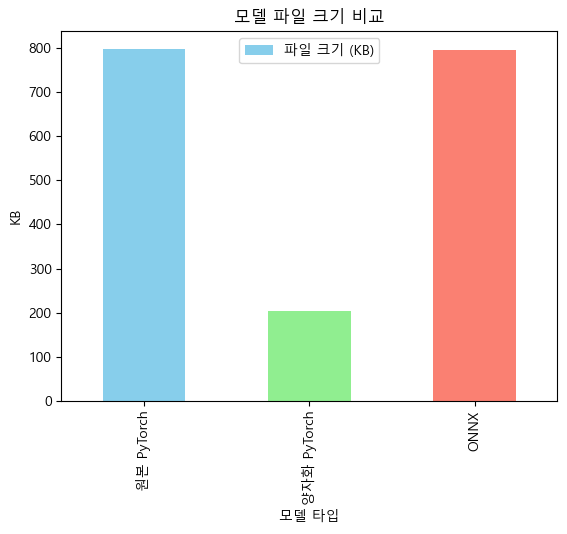

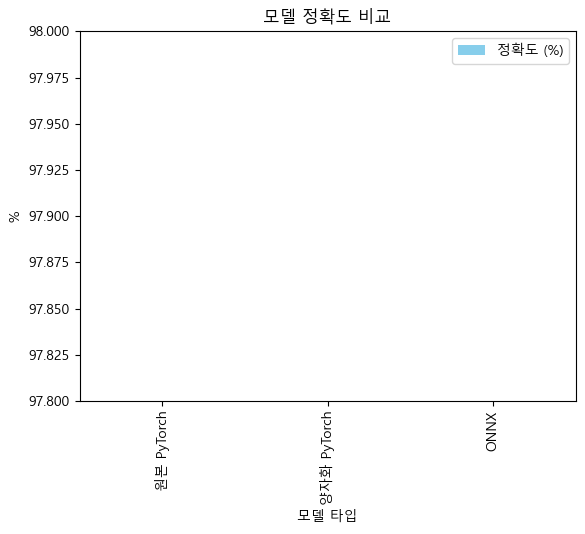

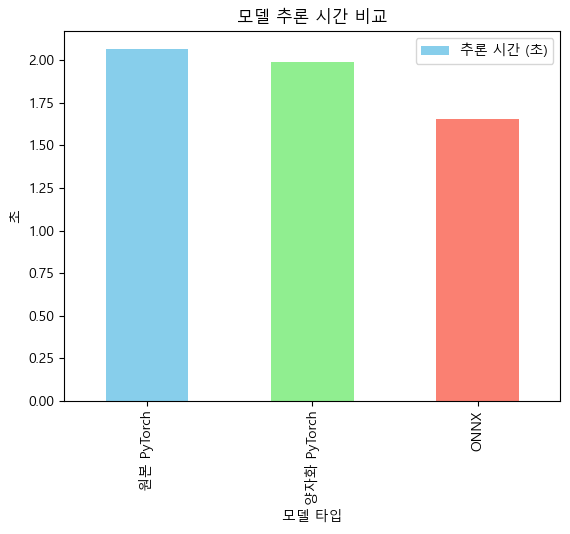

In [52]:
import matplotlib.pyplot as plt

# 파일 크기 비교
results.plot(x='모델 타입', y='파일 크기 (KB)', kind='bar', color=['skyblue','lightgreen','salmon'])
plt.title("모델 파일 크기 비교")
plt.ylabel("KB")
plt.show()

# 정확도 비교
results.plot(x='모델 타입', y='정확도 (%)', kind='bar', color=['skyblue','lightgreen','salmon'])
plt.title("모델 정확도 비교")
plt.ylabel("%")
plt.ylim(97.8, 98.0)  # 확대해서 차이 강조
plt.show()

# 추론 시간 비교
results.plot(x='모델 타입', y='추론 시간 (초)', kind='bar', color=['skyblue','lightgreen','salmon'])
plt.title("모델 추론 시간 비교")
plt.ylabel("초")
plt.show()


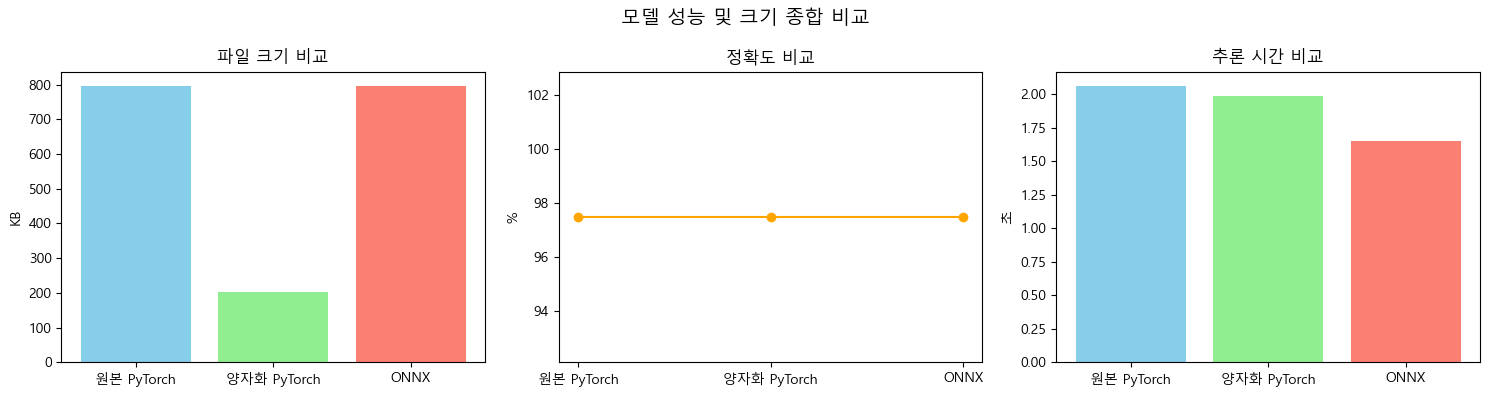

In [54]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# 1️⃣ 파일 크기 (막대 그래프)
axes[0].bar(results['모델 타입'], results['파일 크기 (KB)'], 
            color=['skyblue','lightgreen','salmon'])
axes[0].set_title("파일 크기 비교")
axes[0].set_ylabel("KB")

# 2️⃣ 정확도 (선 그래프)
axes[1].plot(results['모델 타입'], results['정확도 (%)'], 
             marker='o', color='orange')
axes[1].set_title("정확도 비교")
axes[1].set_ylabel("%")
# axes[1].set_ylim(97.8, 98.0)  # 확대해서 차이 강조

# 3️⃣ 추론 시간 (막대 그래프)
axes[2].bar(results['모델 타입'], results['추론 시간 (초)'], 
            color=['skyblue','lightgreen','salmon'])
axes[2].set_title("추론 시간 비교")
axes[2].set_ylabel("초")

plt.suptitle("모델 성능 및 크기 종합 비교", fontsize=14)
plt.tight_layout()
plt.show()
